## Model Evaluation (model v01)

#### Import relevant libraries

In [1]:
import os
import numpy as np
import pandas as pd
from joblib import dump, load

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import mean_absolute_error, mean_squared_error from sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### Load model_fit file

In [3]:
input_dir = os.path.join('..', 'data', 'processed', 'model_v1')
plots_dir = os.path.join('..', 'data', 'figures', 'model_v1')
lin_model = load(os.path.join(input_dir, 'lin_model_3.joblib'))
rf_model = load(os.path.join(input_dir, 'forest_model_1.joblib'))
nnet_model = load(os.path.join(input_dir, 'neural_model_1.joblib'))

#### Load in test and train data

In [4]:
X_train = pd.read_csv(os.path.join(input_dir, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(input_dir, 'X_test.csv'))
y_train = np.array(pd.read_csv(os.path.join(input_dir, 'y_train.csv'))['target'])
y_test = np.array(pd.read_csv(os.path.join(input_dir, 'y_test.csv'))['target'])

In [5]:
X_train = X_train.rename(columns={
    'c09_other_wires': 'c09',
    'c09_restructured': 'c09b',
    'c09_vert_int': 'c09c',
    
})
X_test = X_test.rename(columns={
    'c09_other_wires': 'c09',
    'c09_restructured': 'c09b',
    'c09_vert_int': 'c09c',
    
})

#### Predict on test set using trained models

In [6]:
y_pred_lin = lin_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_nnet = nnet_model.predict(X_test)

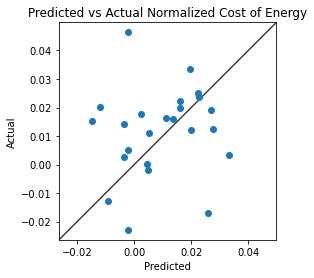

In [7]:
lin_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lin})

fig, ax = plt.subplots()
ax.scatter(y_pred_lin, y_test)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Predicted vs Actual Normalized Cost of Energy')
ax.set_xlim(lims)
ax.set_ylim(lims)

fig.savefig(os.path.join(plots_dir, 'lm_actual_vs_pred_scatter.png'), dpi=300)

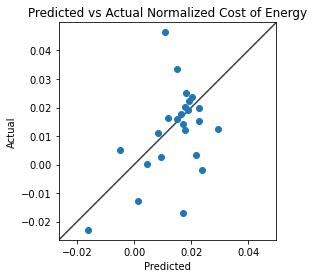

In [8]:
lin_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})

fig, ax = plt.subplots()
ax.scatter(y_pred_rf, y_test)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Predicted vs Actual Normalized Cost of Energy')
ax.set_xlim(lims)
ax.set_ylim(lims)

fig.savefig(os.path.join(plots_dir, 'rf_actual_vs_pred_scatter.png'), dpi=300)

#### Compute fit statistics

(a) Bias := $\sum (\hat{y_i} - y_i) $

In [9]:
bias_lin = sum(y_pred_lin - y_test)
bias_rf = sum(y_pred_rf - y_test)

print("Bias of Linear Regression: {}".format(bias_lin))
print("Bias of Random Forest: {}".format(bias_rf))

Bias of Linear Regression: -0.05941062013762915
Bias of Random Forest: 0.05640617605022746


(b) Mean Absolute Error := $\frac{1}{n} \sum |\hat{y_i} - y_i|$

In [10]:
mae_lin = mean_absolute_error(y_test, y_pred_lin)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("MAE of Linear Regression: {}".format(mae_lin))
print("MAE of Random Forest Model: {}".format(mae_rf))

MAE of Linear Regression: 0.014062349333985964
MAE of Random Forest Model: 0.009820110524489643


(c) Root Mean Square Error := $\sqrt{\frac{1}{n} \sum (\hat{y_i} - y_i)^2}$

In [11]:
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("RMSE of Linear Regression: {}".format(rmse_lin))
print("RMSE of Random Forest: {}".format(rmse_rf))

RMSE of Linear Regression: 0.019210844731974017
RMSE of Random Forest: 0.013973525052173709


(d) R squared := $1 - \frac{RSS}{TSS}$ := $1- \frac{\sum (\hat{y_i}-y_i)^2}{\sum (y_i - \mu)^2}$

In [19]:
r2_lin = r2_score(y_test, y_pred_lin)
r2_rf = r2_score(y_test, y_pred_rf)

print("R^2 of Linear Regression: {}".format(r2_lin))
print("R^2 of Random Forest: {}".format(r2_rf))

R^2 of Linear Regression: -0.5966920216550988
R^2 of Random Forest: 0.15522668423467467


[0.30091652 0.0206658  0.21791344 0.10069361 0.05657034 0.10495912
 0.08603826 0.02429069 0.06272998 0.01726238 0.00362768 0.00433218]


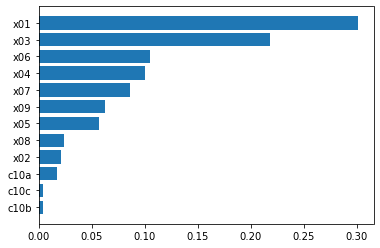

In [20]:
print(rf_model.feature_importances_)
variable_importance_df = pd.DataFrame({
    'variable': np.array(['x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'c10a', 'c10b', 'c10c']),
    'values': rf_model.feature_importances_,
})
variable_importance_df = variable_importance_df.sort_values(by=['values'])
plt.barh(variable_importance_df['variable'], variable_importance_df['values'])
plt.savefig(os.path.join(plots_dir, 'rf_variable_importance_plot.png'), dpi=300)

#### Coefficient value estimates, p-values and std error for each feature variable

In [21]:
results = pd.DataFrame({
    'variables': X_train.columns,
    'coeff': lin_model.coef_,
})
results

,variables,coeff
0,x01,-0.016026
1,x02,0.001193
2,x03,-0.000710
3,x04,-0.002700
4,x05,-0.001419
5,x06,-0.002026
6,x07,0.001904
7,x08,-0.003265
8,x09,-0.003526
9,c10_other_wires,0.003170


Train fit analysis from OLS statsmodel package

In [22]:
import statsmodels.api as sm

In [23]:
X2_train = sm.add_constant(X_train)
ols_result = sm.OLS(y_train, X2_train).fit()
ols_result.summary()

/home/julian/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     3.851
Date:                Mon, 30 May 2022   Prob (F-statistic):           0.000124
Time:                        10:42:46   Log-Likelihood:                 237.09
No. Observations:                  92   AIC:                            -448.2
Df Residuals:                      79   BIC:                            -415.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0147      0.027      0.555      0.580      -0.038       0.068
x01                 -0.0160      0.003     -4.662      0.000      -0.023      -0.009
x02                  0.0012      0.003      0.445      0.658      -0.004       0.007
x03                 -0.0007      0.003     -0.281      0.779      -0.006       0.004
x04                 -0.0027      0.002     -1.240      0.219      -0.007       0.002
x05                 -0.0014      0.002     -0.585      0.560      -0.006       0.003
x06                 -0.0020      0.003     -0.725      0.471      -0.008       0.004
x07                  0.0019      0.002      0.827      0.411      -0.003       0.006
x08                 -0.0033      0.003     -1.066      0.290      -0.009       0.003
x09                 -0.0035      0.003     -1.298      0.198      -0.009       0.002
c10_other_wires      0.0032      0.028      0.114      0.910      -0.052       0.059
c10_restructured     0.0154      0.028      0.552      0.582      -0.040       0.071
c10_vert_int        -0.0086      0.027     -0.325      0.746      -0.061       0.044
==============================================================================
Omnibus:                       26.934   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.328
Skew:                           0.888   Prob(JB):                     2.96e-19
Kurtosis:                       7.371   Cond. No.                         40.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Partial dependence plots